In [1]:
# from https://github.com/cran/GSA/blob/master/R/GSA.read.gmt.R

GSA.read.gmt=function(filename){
#
## Read in and parse a gmt file (gene set file) from the  Broad institute
# this is tricky, because each lines (geneset) has a variable length
#  I read the file twice, first to pick up the geneset name and description
# in the   first two  columns, then I read it all in as a long string

# The beginning and end of each gene set in the string
# is determined by matching
# BOTH on  geneset name and description (since geneset names sometimes
# occur as genenames elsewhere in the file)

a=scan(filename,what=list("",""),sep="\t", quote=NULL, fill=T, flush=T,multi.line=F)
geneset.names=a[1][[1]]

geneset.descriptions=a[2][[1]]

dd=scan(filename,what="",sep="\t", quote=NULL)


nn=length(geneset.names)
n=length(dd)
ox=rep(NA,nn)

ii=1
for(i in 1:nn){
 while((dd[ii]!=geneset.names[i]) | (dd[ii+1]!=geneset.descriptions[i]) ){
  ii=ii+1
  }
 ox[i]=ii
 ii=ii+1
}

genesets=vector("list",nn)

for(i in 1:(nn-1)){
i1=ox[i]+2
i2=ox[i+1]-1
geneset.descriptions[i]=dd[ox[i]+1]
 genesets[[i]]=dd[i1:i2]
}

geneset.descriptions[nn]=dd[ox[nn]+1]
 genesets[[nn]]=dd[(ox[nn]+2):n]
out=list(genesets=genesets,geneset.names=geneset.names, geneset.descriptions=geneset.descriptions)
class(out)="GSA.genesets"
return(out)
}

In [2]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")

# read switches that affect PPIs
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor" & PPI == "1")

# unique genes from the proteome
allGenes <- read_tsv("../data/mutations/proteome_information.txt") %>%
    filter(asEvidence=="True") %>%
    select(GeneId,Symbol) %>%
    unique

# unique drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
    set_colnames(c("Symbol","Tumor")) %>%
    .$Symbol %>%
    unique

# read gene sets
sets <- GSA.read.gmt("../data/genesets/c2.cp.v4.0.entrez.gmt")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



In [3]:
# calculate bilateral fisher test
gsTest <- lapply(sets$genesets, function(gs){
    si <- intersect(gs, unique(switches$GeneId)) %>% length
    so <- setdiff(unique(switches$GeneId), gs) %>% length
    nsi <- length(gs) - si
    nso <- nrow(allGenes) - (si + so + nsi)
    
    f <- c(si,so,nsi,nso) %>% matrix(2,2) %>% fisher.test
    
    c(f$p.value, f$estimate, si,so,nsi,nso)
    
}) %>% do.call("rbind", .) %>%
    as.data.frame %>%
    set_colnames(c("p","OR","si","so","nsi","nso")) %>%
    mutate(geneset = sets$geneset.names,
           adjp = p.adjust(p)) %>%
    arrange(p) %>%
    select(geneset, p, adjp, OR, si, so, nsi, nso)

# count the number of drivers in each gene set
gsTest$NumDrivers <- lapply(sets$genesets, function(gs){
    allGenes %>% filter(Symbol %in% drivers) %>% .$GeneId %>% intersect(gs) %>% length
}) %>% do.call("c",.)

Loading required package: RColorBrewer


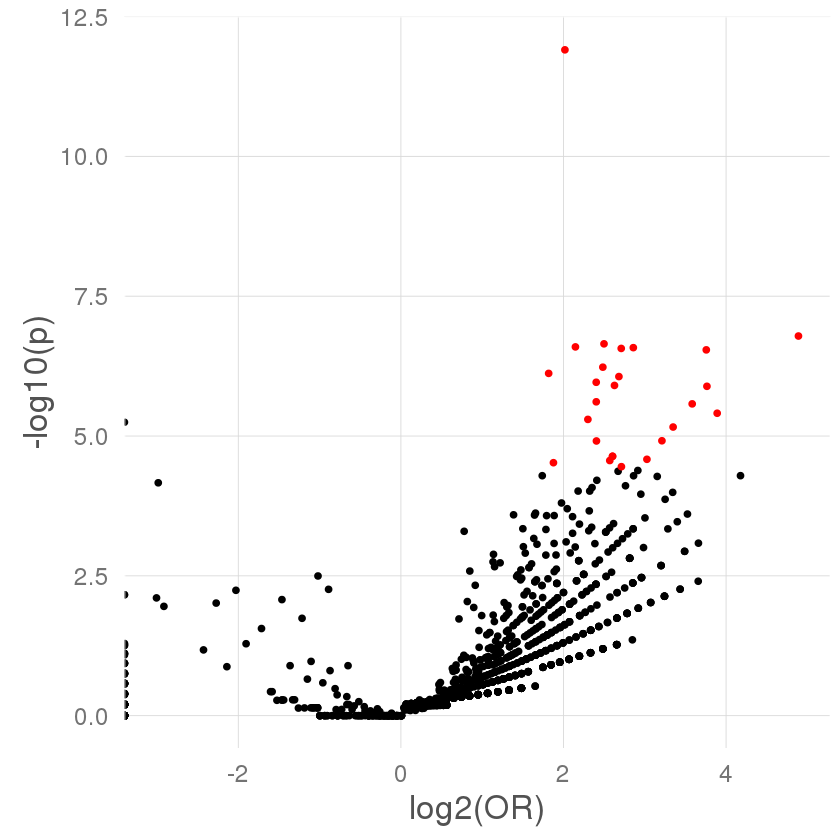

In [4]:
# volcano plot
ggplot() + 
    geom_point(data = subset(gsTest, adjp > 0.05 | OR < 1), aes(x = log2(OR), y = -log10(p))) +
    geom_point(data = subset(gsTest, adjp < 0.05 & OR > 1), aes(x = log2(OR), y = -log10(p)), color = "red") +
    clean_theme()

In [5]:
# sets enriched in ppi switches
gsTest %>%
    filter(adjp < 0.05 & OR > 1)

,geneset,p,adjp,OR,si,so,nsi,nso,NumDrivers
1,KEGG_PATHWAYS_IN_CANCER,1.240621e-12,1.63762e-09,4.049318,43,460,285,12348,1
2,REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,1.62648e-07,0.0002145327,29.65904,7,496,6,12627,3
3,KEGG_PROSTATE_CANCER,2.244279e-07,0.000295796,5.650944,16,487,73,12560,0
4,PID_P53DOWNSTREAMPATHWAY,2.544596e-07,0.0003351233,4.428946,20,483,117,12516,0
5,PID_P53REGULATIONPATHWAY,2.625962e-07,0.0003455765,7.255712,13,490,46,12587,0
6,KEGG_P53_SIGNALING_PATHWAY,2.711525e-07,0.0003565655,6.545125,14,489,55,12578,0
7,BIOCARTA_WNT_PATHWAY,2.876634e-07,0.0003779898,13.51722,9,494,17,12616,0
8,KEGG_SMALL_CELL_LUNG_CANCER,5.870449e-07,0.0007707899,5.595217,15,488,69,12564,2
9,KEGG_FOCAL_ADHESION,7.575539e-07,0.0009939107,3.525377,24,479,177,12456,0
10,PID_RB_1PATHWAY,8.633311e-07,0.001131827,6.416701,13,490,52,12581,0
